# Complementary Filter Synthesis

In [1]:
import pickle

import control
import numpy as np
import matplotlib.pyplot as plt

import kontrol

# Loading the transfer function models of the sensor noises
tf_relative = kontrol.load_transfer_function("tf_relative.pkl")
tf_inertial = kontrol.load_transfer_function("tf_inertial.pkl")

# Create a ComplementaryFilter instance so we can use the synthesis methods.
comp = kontrol.ComplementaryFilter()

# Specifying the noise models.
comp.noise2=tf_relative
comp.noise1=tf_inertial

# Weights are the inverse of the target attenuation.
# In this case, we want to suppress the sensor noise to another one, which ever is lower.
comp.weight2=1/tf_inertial
comp.weight1=1/tf_relative

# Synthesis.
# Note. Sometimes this produces filters that makes no sense, or kind of suboptimal.
# If that happens, try interchanging the number 1 and 2 from the above noise and weight specifications.
# (This is one of the cases so we happened to start with 2, instead of 1.)
h2, h1 = comp.hinfsynthesis()

In [2]:
# Sometimes the filters may contain meaningless coefficients that corresponds to
# zeros or poles at extremely high frequencies.
# This will become a problem during implementation so it's best to get rid of them now.
# In this case, we have one such coefficient in h1. The first numerator coefficient is an outlier.
# print(h1)  # < uncomment this line to see it.

# To get rid of it, we define a new filter using the numerator and denominator of h1, without that coefficient.
h1 = control.tf(h1.num[0][0][1:], h1.den[0][0])
h2 = 1 - h1
# ^Doing the above should not change the result or performance.
# (Just make sure this block is ran only once.)
# Optionally, we can plot the new and old filters to see if they match.

Text(0.5, 0, 'Frequency (Hz)')

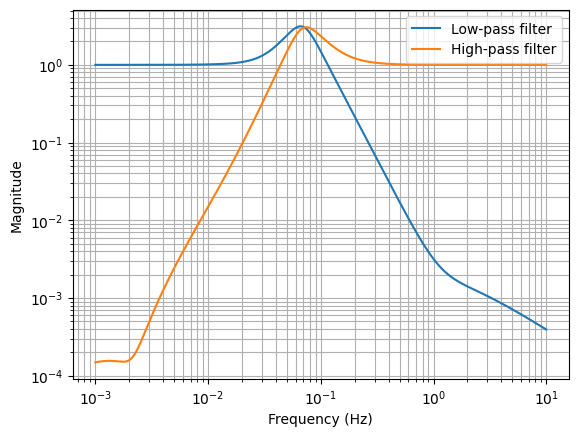

In [5]:
# Inspect the filters
f = np.logspace(-3, 1, 1024)
plt.loglog(f, abs(h1(1j*2*np.pi*f)), label="Low-pass filter")
plt.loglog(f, abs(h2(1j*2*np.pi*f)), label="High-pass filter")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")

Text(0.5, 0, 'Frequency (Hz)')

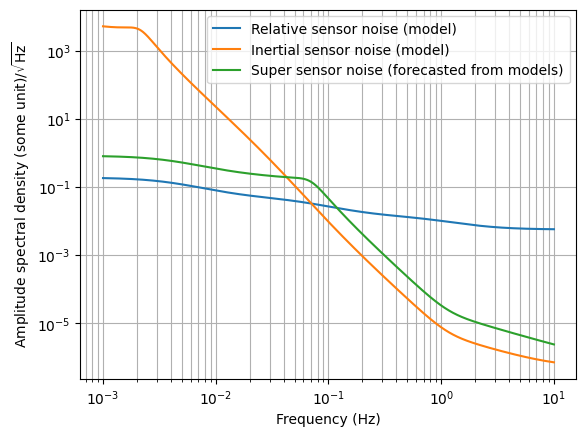

In [6]:
# Now let's forecast the noise of the super sensor.
plt.loglog(f, abs(tf_relative(1j*2*np.pi*f)), label="Relative sensor noise (model)")
plt.loglog(f, abs(tf_inertial(1j*2*np.pi*f)), label="Inertial sensor noise (model)")
plt.loglog(f, comp.noise_super(f), label="Super sensor noise (forecasted from models)")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude spectral density (some unit)/$\sqrt{\mathrm{Hz}}$")
plt.xlabel("Frequency (Hz)")

Text(0.5, 0, 'Frequency (Hz)')

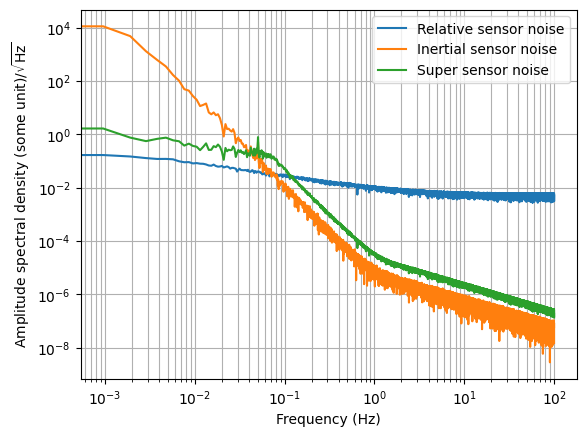

In [7]:
# As you can see, with these weight specifications, the complementary filters
# are perfectly shaped in such a way the super sensor noise is suppressed everywhere
# (except at the blending frequency).
# The super sensor noise has a multiplificative factor from the lower boundary
# and it turned out to be the H-infinity norm, which is what the H-infinity synthesis minimizes.
# Because of this, the super sensor noise looks equidistant from the lower boundary
# at all frequencies in a loglog plot.
# If this is not what we want, we can always specify custom specifications using the weights.
# And in that case, the H-infinity norm represents the deviation from the specifications.

# Now, we must note that the filters are only optimal with respect to the cost function,
# which is derived from the flattened noise spectrum.
# Let's import the realistic sensor noises that we measured
# and see how the complementary filters realistically perform.

# Import sensor noise data
with open("noise_spectrum_frequency.pkl", "rb") as fh:
    f_ = pickle.load(fh)
with open("noise_spectrum_relative.pkl", "rb") as fh:
    noise_relative = pickle.load(fh)
with open("noise_spectrum_inertial.pkl", "rb") as fh:
    noise_inertial = pickle.load(fh)


# Inspect. Actually looks fine, with one caveat.
plt.loglog(f_, noise_relative, label="Relative sensor noise")
plt.loglog(f_, noise_inertial, label="Inertial sensor noise")
plt.loglog(f_, comp.noise_super(f_, noise1=noise_inertial, noise2=noise_relative), label="Super sensor noise")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude spectral density (some unit)/$\sqrt{\mathrm{Hz}}$")
plt.xlabel("Frequency (Hz)")

Text(0.5, 0, 'Frequency (Hz)')

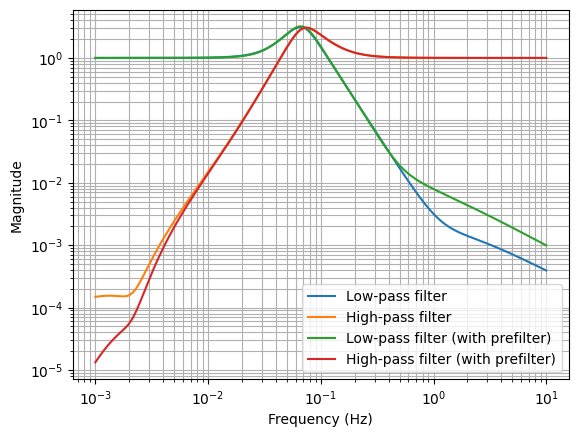

In [8]:
# Note how the how-pass filter becomes flattened below 2e-3 Hz.
# That's because we had to flatten the noise spectrum at both ends in order to use the H-infinity method.
# In practice, we want to keep the roll-off until 0 Hz to avoid integration error.
# There are many ways to achieve this.
# Here we'll use an extremely simple method.

# Add a 3rd-order high-pass prefilter to the high-pass filter
# Note. We're matching the order of the roll-off to the complementary high-pass.
# It could be 3/4.
s = control.tf("s")
wc = 2*np.pi*2e-3  # cut-off frequency
prefilter = (s / (s+wc))**3

# Redefine the complementary high-pass filter and  low-pass filter.
h2_prefilt = h2 * prefilter
h1_prefilt = 1 - h2_prefilt  # Complementary condition.

# Inspect
plt.loglog(f, abs(h1(1j*2*np.pi*f)), label="Low-pass filter")
plt.loglog(f, abs(h2(1j*2*np.pi*f)), label="High-pass filter")
plt.loglog(f, abs(h1_prefilt(1j*2*np.pi*f)), label="Low-pass filter (with prefilter)")
plt.loglog(f, abs(h2_prefilt(1j*2*np.pi*f)), label="High-pass filter (with prefilter)")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Magnitude")
plt.xlabel("Frequency (Hz)")

Text(0.5, 0, 'Frequency (Hz)')

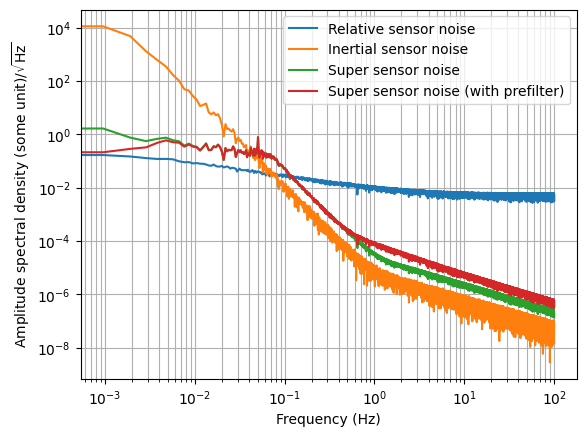

In [9]:
# New forecast.
plt.loglog(f_, noise_relative, label="Relative sensor noise")
plt.loglog(f_, noise_inertial, label="Inertial sensor noise")
plt.loglog(f_, comp.noise_super(f_, noise1=noise_inertial, noise2=noise_relative), label="Super sensor noise")
plt.loglog(f_, comp.noise_super(f_, noise1=noise_inertial, noise2=noise_relative, filter1=h2_prefilt, filter2=h1_prefilt), label="Super sensor noise (with prefilter)")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude spectral density (some unit)/$\sqrt{\mathrm{Hz}}$")
plt.xlabel("Frequency (Hz)")

In [10]:
# As can be seen, the addition of the high-pass prefilter provides further suppression at low-frequency
# and this should prevent integration error from accumulating.
# However, it also rises the sensor noise at above 1 Hz and this is the trade-off that we have to make.
# We can lower that by tweaking the order and cut-off frequency of the prefilter.
# But we're not geting into that and let's assume that the super sensor noise level is acceptable.

# Again, to export the filters to Foton string so we can install them, we can use kontrol.TransferFunction.
print("Low-pass with prefilt\n", kontrol.TransferFunction(h1_prefilt).foton(root_location="n"), "\n")
print("High-pass\n", kontrol.TransferFunction(h2_prefilt).foton(root_location="n"), "\n")
print("High-pass Prefilter\n", kontrol.TransferFunction(prefilter).foton(root_location="n"))
# ^Printing the prefilter separately because we might have this at a different filter bank,
# such as the input filters for the inertial sensors.

Low-pass with prefilt
 zpk([0.00185588;0.002061+i*0.000170;0.002061+i*-0.000170;0.00376473;0.00381207;0.023713+i*0.025604;0.023713+i*-0.025604;0.038824;0.0561513;0.117467;0.195753;0.304844+i*0.410168;0.304844+i*-0.410168;1.70477;2.06538;10.6556],[0.00199992;0.002000+i*0.000000;0.002000+i*-0.000000;0.00376472;0.00376474;0.0511919;0.055021+i*-0.011625;0.055021+i*0.011625;0.051606+i*-0.040288;0.051606+i*0.040288;0.022296+i*-0.065921;0.022296+i*0.065921;0.195169;0.196346;2.06538;2.06539;11.3038],1,"n") 

High-pass
 zpk([-0;-0;-0;0.000592232;0.000587+i*-0.002051;0.000587+i*0.002051;0.00376473;0.014638;0.0332445;0.055905;0.122886+i*-0.075068;0.122886+i*0.075068;0.154938;0.195764;2.06394;2.06538;11.3032],[0.00199988;0.002000+i*0.000000;0.002000+i*-0.000000;0.00376472;0.00376474;0.0511919;0.055021+i*-0.011625;0.055021+i*0.011625;0.051606+i*-0.040288;0.051606+i*0.040288;0.022296+i*-0.065921;0.022296+i*0.065921;0.195169;0.196346;2.06538;2.06539;11.3038],11883.2,"n") 

High-pass Prefilter
 zpk([-